<a href="https://colab.research.google.com/github/AnzilShahjahan/AnzilShahjahan--Data-Science---Gen-AI-Submission/blob/main/5_02_Modelling_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1xqQczl0FG-qtNA2_WQYuWePW9oU8irqJ)

# 5.02 Modelling Hackathon
We'll get a chance in this seminar to practice for the in-class test, and also to put what we have learned into practice.

To speed things up, I have done the data/feature engineering for you, you will just need to build it into a data science model. As before, you can use the code from [GitHub](https://github.com/MJMortensonWarwick/IB2AD0_Data_Science_GenerativeAI), from the internet, and/or use the Gemini AI tools.

This is an artificial dataset, and we will be predicting if students achieve a passing grade, which we will call anything above a "D".

We'll start by importing the data:

In [86]:
from google.colab import files
upload = files.upload()

Saving students_two.csv to students_two (4).csv


Now we will get the data into Pandas and inspect it:

In [87]:
import pandas as pd
df = pd.read_csv("students_two.csv")

df.head()

,Id,Student_Age,High_School_Type,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade
0,5001,21,Other,50%,Yes,No,Private,0,Always,Yes,Yes,No,No,AA
1,5002,20,Other,50%,Yes,No,Private,0,Always,Yes,No,Yes,Yes,AA
2,5003,21,State,50%,No,No,Private,2,Never,No,No,No,Yes,AA
3,5004,18,Private,50%,Yes,No,Bus,2,Always,No,Yes,No,No,AA
4,5005,22,Private,50%,No,No,Bus,12,Always,Yes,No,Yes,Yes,AA


Let's check for missing values:

In [88]:
df.isnull().sum()

,0
Id,0
Student_Age,0
High_School_Type,0
Scholarship,1
Additional_Work,0
Sports_activity,0
Transportation,0
Weekly_Study_Hours,0
Attendance,0
Reading,0


Only one missing value. Let's just drop it out of laziness:

In [89]:
df.dropna(inplace=True)
df.isnull().sum()

,0
Id,0
Student_Age,0
High_School_Type,0
Scholarship,0
Additional_Work,0
Sports_activity,0
Transportation,0
Weekly_Study_Hours,0
Attendance,0
Reading,0


We have an ID column we know won't be predictive ... so let's drop it:

In [90]:
df = df.drop(["Id"], axis=1)
df.head()

,Student_Age,High_School_Type,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade
0,21,Other,50%,Yes,No,Private,0,Always,Yes,Yes,No,No,AA
1,20,Other,50%,Yes,No,Private,0,Always,Yes,No,Yes,Yes,AA
2,21,State,50%,No,No,Private,2,Never,No,No,No,Yes,AA
3,18,Private,50%,Yes,No,Bus,2,Always,No,Yes,No,No,AA
4,22,Private,50%,No,No,Bus,12,Always,Yes,No,Yes,Yes,AA


Next we will convert some of the text features to numbers:

In [91]:
# High school
print(df['High_School_Type'].unique())

['Other' 'State' 'Private']


We can't easily convert these to a number range. Instead we should use one-hot encoding:

In [92]:
df = pd.get_dummies(df, columns=['High_School_Type'], drop_first=True, dtype=int)
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,50%,Yes,No,Private,0,Always,Yes,Yes,No,No,AA,0,0
1,20,50%,Yes,No,Private,0,Always,Yes,No,Yes,Yes,AA,0,0
2,21,50%,No,No,Private,2,Never,No,No,No,Yes,AA,0,1
3,18,50%,Yes,No,Bus,2,Always,No,Yes,No,No,AA,1,0
4,22,50%,No,No,Bus,12,Always,Yes,No,Yes,Yes,AA,1,0


We have converted this to two columns (on the far right) - "High_School_Type_Private" and "High_School_Type_State". We do not need the "Other" type as if the student is "Other" then both "Private" and "State" will be 0 (a unique combination). This is controlled by the command _drop\_first=True_. We also specify the data type (_dtype_) as __int__ so we return 0s and 1s rather than True and False.

Next we can look at Scholarship. It needs to be converted from a text representation of a percentage to a number:

In [93]:
df['Scholarship'] = df['Scholarship'].str.replace('%', '').astype(float) / 100
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,Yes,No,Private,0,Always,Yes,Yes,No,No,AA,0,0
1,20,0.5,Yes,No,Private,0,Always,Yes,No,Yes,Yes,AA,0,0
2,21,0.5,No,No,Private,2,Never,No,No,No,Yes,AA,0,1
3,18,0.5,Yes,No,Bus,2,Always,No,Yes,No,No,AA,1,0
4,22,0.5,No,No,Bus,12,Always,Yes,No,Yes,Yes,AA,1,0


"Additional_Work" is next:

In [94]:
# Additional work
print(df['Additional_Work'].unique())

['Yes' 'No']


Two values, so we can convert to 0 and 1:

In [95]:
df['Additional_Work'] = df['Additional_Work'].map({'Yes': 1, 'No': 0})
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,No,Private,0,Always,Yes,Yes,No,No,AA,0,0
1,20,0.5,1,No,Private,0,Always,Yes,No,Yes,Yes,AA,0,0
2,21,0.5,0,No,Private,2,Never,No,No,No,Yes,AA,0,1
3,18,0.5,1,No,Bus,2,Always,No,Yes,No,No,AA,1,0
4,22,0.5,0,No,Bus,12,Always,Yes,No,Yes,Yes,AA,1,0


Let's speed up now:

In [96]:
categorical_cols = ['Sports_activity', 'Transportation', 'Attendance', 'Reading', 'Notes', 'Listening_in_Class', 'Project_work', 'Grade']

for col in categorical_cols:
    print(f"Unique values for '{col}': {df[col].unique()}")

Unique values for 'Sports_activity': ['No' 'Yes']
Unique values for 'Transportation': ['Private' 'Bus']
Unique values for 'Attendance': ['Always' 'Never' 'Sometimes' '3']
Unique values for 'Reading': ['Yes' 'No']
Unique values for 'Notes': ['Yes' 'No' '6']
Unique values for 'Listening_in_Class': ['No' 'Yes' '6']
Unique values for 'Project_work': ['No' 'Yes']
Unique values for 'Grade': ['AA' 'BA' 'CC' 'Fail' 'BB' 'CB' 'DD' 'DC']


The values of '6' in 'Notes' and 'Listening_in_Class' make no sense, and neither do '3' for 'Attendance'. We'll be lazy and drop these rows (really we should check with an SME):

In [97]:
df = df[(df['Notes'] != '6') & (df['Listening_in_Class'] != '6') & (df['Attendance'] != '3')]
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,No,Private,0,Always,Yes,Yes,No,No,AA,0,0
1,20,0.5,1,No,Private,0,Always,Yes,No,Yes,Yes,AA,0,0
2,21,0.5,0,No,Private,2,Never,No,No,No,Yes,AA,0,1
3,18,0.5,1,No,Bus,2,Always,No,Yes,No,No,AA,1,0
4,22,0.5,0,No,Bus,12,Always,Yes,No,Yes,Yes,AA,1,0


Now we can convert all those "Yes" / "No" columns to 0 and 1.

In [98]:
binary_cols = ['Sports_activity', 'Reading', 'Notes', 'Listening_in_Class', 'Project_work']

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,Private,0,Always,1,1,0,0,AA,0,0
1,20,0.5,1,0,Private,0,Always,1,0,1,1,AA,0,0
2,21,0.5,0,0,Private,2,Never,0,0,0,1,AA,0,1
3,18,0.5,1,0,Bus,2,Always,0,1,0,0,AA,1,0
4,22,0.5,0,0,Bus,12,Always,1,0,1,1,AA,1,0


We can also do this with "Transportation":

In [99]:
df['Transportation'] = df['Transportation'].map({'Private': 1, 'Bus': 0})
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,1,0,Always,1,1,0,0,AA,0,0
1,20,0.5,1,0,1,0,Always,1,0,1,1,AA,0,0
2,21,0.5,0,0,1,2,Never,0,0,0,1,AA,0,1
3,18,0.5,1,0,0,2,Always,0,1,0,0,AA,1,0
4,22,0.5,0,0,0,12,Always,1,0,1,1,AA,1,0


For Attendance an ordinal range makes sense:

In [100]:
df['Attendance'] = df['Attendance'].map({'Never': 0, 'Sometimes': 1, 'Always': 2})
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,1,0,2,1,1,0,0,AA,0,0
1,20,0.5,1,0,1,0,2,1,0,1,1,AA,0,0
2,21,0.5,0,0,1,2,0,0,0,0,1,AA,0,1
3,18,0.5,1,0,0,2,2,0,1,0,0,AA,1,0
4,22,0.5,0,0,0,12,2,1,0,1,1,AA,1,0


This just leaves the target - 'Grade'. To make the problem binary we'll convert 'Fail' and any grade that includes a 'D' as 0 (for fail) and the rest as 1 (pass):

In [101]:
df['Grade'] = df['Grade'].apply(lambda x: 0 if x == 'Fail' or 'D' in x else 1)
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,1,0,2,1,1,0,0,1,0,0
1,20,0.5,1,0,1,0,2,1,0,1,1,1,0,0
2,21,0.5,0,0,1,2,0,0,0,0,1,1,0,1
3,18,0.5,1,0,0,2,2,0,1,0,0,1,1,0
4,22,0.5,0,0,0,12,2,1,0,1,1,1,1,0


The code has a new function `lambda`. A lambda function in Python is a small, anonymous function. It's defined using the `lambda` keyword and can take any number of arguments, but can only have one expression. The expression is evaluated and returned. They are often used for short, simple operations where a full function definition would be overly verbose, like in the apply method we just used. Although the function is new, the actual mechanics are quite simple. If the data is "Fail" or contains "D" return 0, and else return 1.

As this is the target we will create a new variable from it and then drop it from the main data:

In [102]:
Y_values = df[['Grade']].values.ravel() # change to list

Y_values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1])

In [103]:
X_values = df.drop(['Grade'], axis=1)
X_values.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,1,0,2,1,1,0,0,0,0
1,20,0.5,1,0,1,0,2,1,0,1,1,0,0
2,21,0.5,0,0,1,2,0,0,0,0,1,0,1
3,18,0.5,1,0,0,2,2,0,1,0,0,1,0
4,22,0.5,0,0,0,12,2,1,0,1,1,1,0


We can now scale X:

In [104]:
from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler object
scaler = MinMaxScaler()

# fit and transform the data and convert back to DataFrame
X_values = pd.DataFrame(scaler.fit_transform(X_values), columns=X_values.columns)
X_values

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,High_School_Type_Private,High_School_Type_State
0,0.375,0.333333,1.0,0.0,1.0,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.250,0.333333,1.0,0.0,1.0,0.000000,1.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.375,0.333333,0.0,0.0,1.0,0.166667,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.000,0.333333,1.0,0.0,0.0,0.166667,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.500,0.333333,0.0,0.0,0.0,1.000000,1.0,1.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.500,0.333333,1.0,1.0,1.0,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,1.0
136,0.000,0.666667,0.0,0.0,1.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,1.0
137,0.000,0.666667,0.0,0.0,1.0,0.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0
138,0.500,0.666667,1.0,1.0,0.0,1.000000,0.5,0.0,1.0,0.0,1.0,0.0,1.0


And now we can split into training and test:

In [105]:
# split data into training and test
from sklearn.model_selection  import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_values, Y_values, test_size = 0.2, random_state=1984, stratify=Y_values)

# print the shapes to check everything is OK
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(112, 13)
(28, 13)
(112,)
(28,)


And now its time for modelling ...



Your turn :)

In [107]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the model
dt_classifier.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=42)

In [108]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test set
Y_pred = dt_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.6429
Precision: 0.7619
Recall: 0.7619
F1-Score: 0.7619


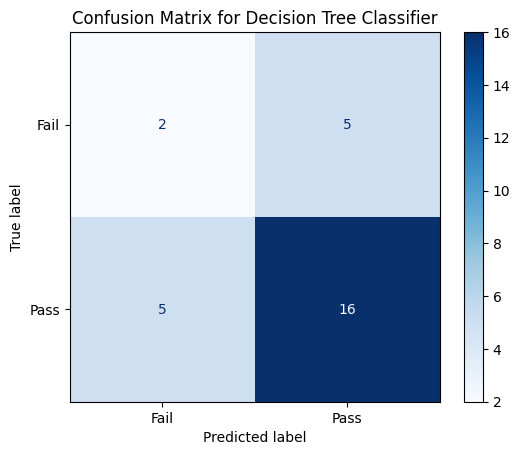

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fail', 'Pass'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()

In [109]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test set
Y_pred = dt_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.6429
Precision: 0.7619
Recall: 0.7619
F1-Score: 0.7619


# Task
Optimize the Decision Tree Classifier using randomized search for hyperparameter tuning, then evaluate the best model's performance with accuracy, precision, recall, and F1-score, and visualize the results using a confusion matrix.

## Define Hyperparameters and Setup Randomized Search

### Subtask:
Import necessary libraries and define the hyperparameter search space for the Decision Tree Classifier, then set up the RandomizedSearchCV object.


**Reasoning**:
First, I'll import the necessary libraries for hyperparameter tuning and define the search space for the Decision Tree Classifier as instructed.



In [111]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the hyperparameter search space for DecisionTreeClassifier
param_dist = {
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_leaf': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'criterion': ['gini', 'entropy']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=dt_classifier, param_distributions=param_dist,
                                   n_iter=100, cv=5, random_state=42, scoring='f1', n_jobs=-1)

print("RandomizedSearchCV object and parameter distribution defined.")

RandomizedSearchCV object and parameter distribution defined.


**Reasoning**:
Now that the `RandomizedSearchCV` object is initialized, the next step is to fit it to the training data to perform the hyperparameter tuning and find the best model.



In [112]:
random_search.fit(X_train, Y_train)

print("Randomized search completed.")

Randomized search completed.


**Reasoning**:
After fitting the `RandomizedSearchCV`, it's important to inspect the best parameters and the best score found to understand the results of the hyperparameter tuning.



In [113]:
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1 score: {random_search.best_score_:.4f}")

Best parameters found: {'criterion': 'entropy', 'max_depth': 40, 'min_samples_leaf': 7, 'min_samples_split': 12}
Best F1 score: 0.8676


**Reasoning**:
Now that the best parameters have been identified through randomized search, I will retrieve the best model (estimator) from the `random_search` object. This best model will then be used to make predictions on the test set, which is crucial for evaluating its performance.



In [114]:
best_dt_classifier = random_search.best_estimator_
Y_pred_optimized = best_dt_classifier.predict(X_test)

print("Predictions made with the optimized Decision Tree Classifier.")

Predictions made with the optimized Decision Tree Classifier.


**Reasoning**:
Now that predictions have been made with the optimized model, I need to evaluate its performance using standard classification metrics: accuracy, precision, recall, and F1-score, as specified in the task.



In [115]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate evaluation metrics for the optimized model
accuracy_optimized = accuracy_score(Y_test, Y_pred_optimized)
precision_optimized = precision_score(Y_test, Y_pred_optimized)
recall_optimized = recall_score(Y_test, Y_pred_optimized)
f1_optimized = f1_score(Y_test, Y_pred_optimized)

print(f"Optimized Model Accuracy: {accuracy_optimized:.4f}")
print(f"Optimized Model Precision: {precision_optimized:.4f}")
print(f"Optimized Model Recall: {recall_optimized:.4f}")
print(f"Optimized Model F1-Score: {f1_optimized:.4f}")

Optimized Model Accuracy: 0.7857
Optimized Model Precision: 0.8261
Optimized Model Recall: 0.9048
Optimized Model F1-Score: 0.8636


**Reasoning**:
To complete the evaluation and visualization for the optimized model, I will generate and display a confusion matrix, which provides a detailed breakdown of correct and incorrect classifications, as requested in the main task.



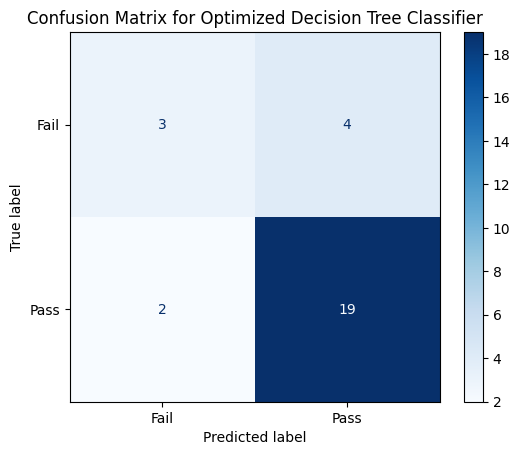

Confusion matrix for the optimized model displayed.


In [116]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix for the optimized model
cm_optimized = confusion_matrix(Y_test, Y_pred_optimized)

# Display the confusion matrix
disp_optimized = ConfusionMatrixDisplay(confusion_matrix=cm_optimized, display_labels=['Fail', 'Pass'])
disp_optimized.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Optimized Decision Tree Classifier')
plt.show()
print("Confusion matrix for the optimized model displayed.")

## Summary:

### Data Analysis Key Findings
*   The randomized search identified the best hyperparameters for the Decision Tree Classifier as: `{'criterion': 'entropy', 'max_depth': 40, 'min_samples_leaf': 7, 'min_samples_split': 12}`.
*   The best F1 score achieved during the randomized search cross-validation was approximately 0.8676.
*   The optimized Decision Tree Classifier achieved an accuracy of 0.7857 on the test set.
*   The optimized model demonstrated a precision of 0.8261, a recall of 0.9048, and an F1-score of 0.8636 on the test set.
*   A confusion matrix was successfully generated and displayed, visually representing the optimized model's classification performance.

### Insights or Next Steps
*   The optimized Decision Tree Classifier shows a strong recall score (0.9048), indicating its effectiveness in identifying positive cases, which could be critical depending on the problem's context (e.g., minimizing false negatives).
*   Further analysis of the confusion matrix could reveal specific areas where the model struggles (e.g., distinguishing between false positives and false negatives) and guide feature engineering or more complex model architectures.
